# H1N1 and Seasonal Flu Vaccines

## Business Understanding

The COVID-19 pandemic reshaped our understanding of how society responds to a common crisis and recentered the conversation around public health. In order to provide guidance for future public health efforts, this analysis revisits the 2009 public health response to the H1N1 influenza virus and attempts to understand how people’s backgrounds, opinions, and health behaviors are related to their personal vaccination pattern.

## Data Understanding

**H1N1**

Beginning in spring 2009, a pandemic caused by the H1N1 influenza virus, colloquially named "swine flu," swept across the world. Researchers estimate that in the first year, it was responsible for between 151K - 575K deaths globally. A vaccine for the H1N1 flu virus became publicly available in October 2009. 

In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. 

**Survey Data**

Using this survey data, acquired from the [National Center for Health Statistics](https://www.cdc.gov/nchs/nis/data_files_h1n1.htm), the predictive model below attempts to classify whether or not an individual received an H1N1 vaccination based on various personal opinions and behaviors.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# import data

features_df = pd.read_csv("data/Training_Features.csv", index_col="respondent_id")
labels_df = pd.read_csv("data/Training_Labels.csv", index_col="respondent_id")
df = features_df.join(labels_df)

### Target

Of approximately 27K respondents, only 21% had opted to receive the H1N1 vaccine (compared to 47% for the seasonal flu vaccine). 

In [9]:
# percentage breakdown of binary classes for H1N1 vaccination rate
labels_df["h1n1_vaccine"].value_counts(normalize=True)*100

0    78.754634
1    21.245366
Name: h1n1_vaccine, dtype: float64

In [ ]:
# percentage breakdown of binary classes forseasonal flu vaccination rate
labels_df["seasonal_vaccine"].value_counts(normalize=True)*100

0    53.439173
1    46.560827
Name: seasonal_vaccine, dtype: float64

### Features

The survey covered 35 unique features that we grouped into four categories:
    - vaccine opinion, such as general knowledge of H1N1 and concern of getting sick from the virus or vaccine
    - medical concern, such as if doctors' recommendedation on receiving the vaccine or having a chronic medical condition
    - behavioral patterns, such as avoiding large gatherings or wearing face masks
    - demographics, such as age, employment, location, etc.

Vaccination levels remained fairly consistent across different classes of behavioral patterns and demographics, while vaccine opinions and medical concern seem to have a wider variance in vaccination levels across different features classes.
A notable outlier in the demographic features is employment occupation & industry where certain classes appeared to have much higher vaccination levels than the average.

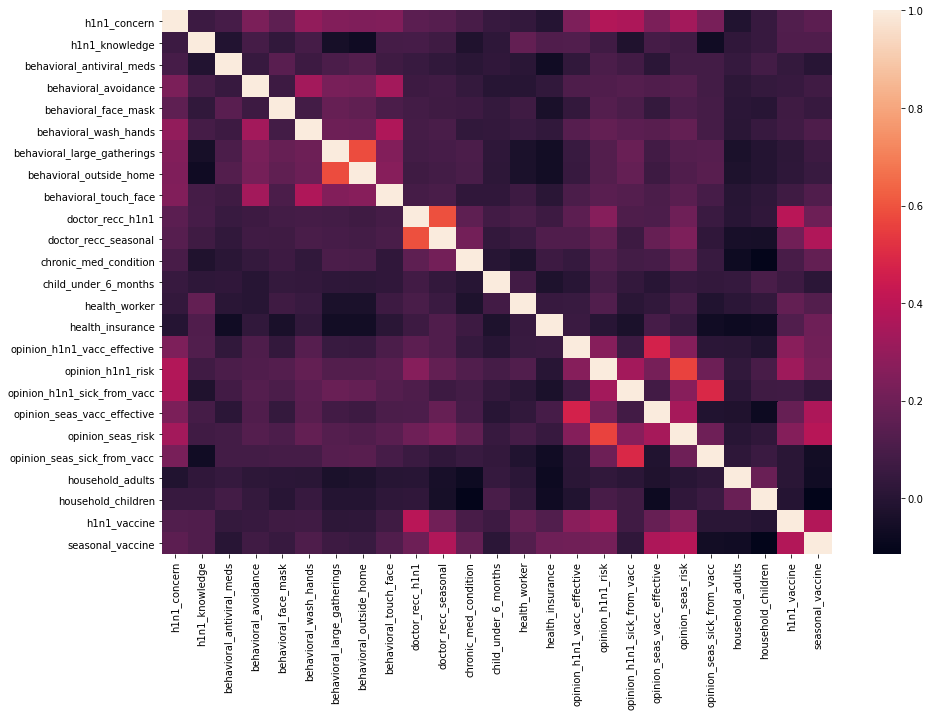

In [18]:
# plot correlation heatmap

plt.figure(figsize=(15,10))
sns.heatmap(df.corr());

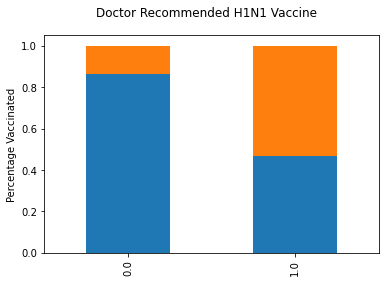

In [19]:
# set feature and target
feature = 'doctor_recc_h1n1'
target = 'h1n1_vaccine'

# plot
counts = df[[feature, target]].groupby([feature, target]).size().unstack()
perc = counts.div(counts.sum(axis='columns'), axis='index')
perc.plot.bar(stacked=True, legend=False)
plt.ylabel('Percentage Vaccinated')
plt.xlabel('')

# set title
plt.suptitle('Doctor Recommended H1N1 Vaccine');

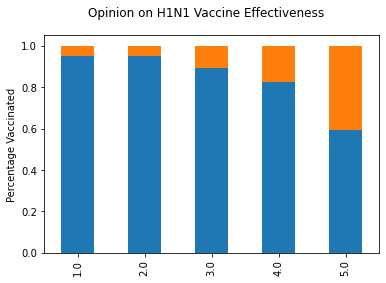

In [20]:
# set feature and target
feature = 'opinion_h1n1_vacc_effective'
target = 'h1n1_vaccine'

# plot
counts = df[[feature, target]].groupby([feature, target]).size().unstack()
perc = counts.div(counts.sum(axis='columns'), axis='index')
perc.plot.bar(stacked=True, legend=False)
plt.ylabel('Percentage Vaccinated')
plt.xlabel('')

# set title
plt.suptitle('Opinion on H1N1 Vaccine Effectiveness');

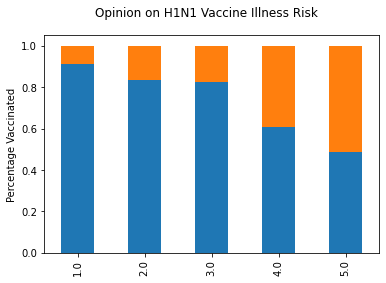

In [21]:
# set feature and target
feature = 'opinion_h1n1_risk'
target = 'h1n1_vaccine'

# plot
counts = df[[feature, target]].groupby([feature, target]).size().unstack()
perc = counts.div(counts.sum(axis='columns'), axis='index')
perc.plot.bar(stacked=True, legend=False)
plt.ylabel('Percentage Vaccinated')
plt.xlabel('')

# set title
plt.suptitle('Opinion on H1N1 Vaccine Illness Risk');

In [23]:
# define columns to drop before training

cols_to_drop = [
    # high nulls
    'health_insurance',
    # demographics
    'age_group',
    'education',
    'race',
    'sex',
    'marital_status',
    'employment_status',
    'employment_industry',
    'employment_occupation',
    'income_poverty',
    'rent_or_own',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    # targets
    'h1n1_vaccine',
    'seasonal_vaccine'
]


## Modeling & Evaluation


The final model, a random forest classifier, maximizes the precision score, a measure of the true positive rate. This model focuses on minimizing the false positives- that is to say the prediction someone did get the vaccine when they actually did not.

After running  basic predictive models and then tuning parameters to maximize the precision score, the model reached 83% accuracy with 70% precision.

In [24]:
# define X and y 
X = df.drop(columns= cols_to_drop)
y = df['h1n1_vaccine']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
num_cols = X.columns[X.dtypes != 'object'].to_list()
cat_cols = X.columns[X.dtypes == 'object'].to_list()

### Preprocessing

In [26]:
# impute and scale

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# cat_transformer = Pipeline([  ])
# if you don't drop demo columns before training, add transformer to one-hot-encode categorical variables


In [27]:
preprocessor = ColumnTransformer(
    transformers =[
        ("numeric_transformer", num_transformer, num_cols)
        # ("categorical_transformer", cat_transformer, cat_cols)
        ])

## Dummy Model

accuracy score - 79%

In [28]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.7875497308682424

In [29]:
y_pred_dummy = dummy.predict(X_test)
accuracy_score(y_test, y_pred_dummy)

0.7875327592661925

In [30]:
dummy_a = cross_val_score(dummy, X_train, y_train, scoring='accuracy').mean()

## Decision Tree

In [31]:
dt2 = DecisionTreeClassifier(
    random_state=42,
    class_weight=None,
    max_depth=2,
    min_samples_leaf=5,
    min_samples_split=2
)

In [32]:
dt_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt2)
])

In [33]:
cross_validate(dt_tuned, X_train, y_train, return_train_score=True, scoring=['accuracy', 'precision'])

{'fit_time': array([0.03465104, 0.02411079, 0.02945399, 0.0251739 , 0.03104377]),
 'score_time': array([0.00452304, 0.00345206, 0.00332594, 0.00339103, 0.00287819]),
 'test_accuracy': array([0.82050082, 0.8212029 , 0.82377721, 0.81979874, 0.81722443]),
 'train_accuracy': array([0.82050082, 0.8203253 , 0.81968172, 0.82067634, 0.82131992]),
 'test_precision': array([0.68041237, 0.70571429, 0.72594752, 0.70294118, 0.67887324]),
 'train_precision': array([0.70317003, 0.69635344, 0.69155618, 0.69707521, 0.70302604])}

In [34]:
dt2_a = cross_val_score(dt_tuned, X_train, y_train, scoring='accuracy').mean()
dt2_p = cross_val_score(dt_tuned, X_train, y_train, scoring='precision').mean()

## Random Forest

In [35]:
rf2 = RandomForestClassifier(
    random_state=42,
    class_weight=None,
    max_depth=8,
    min_samples_leaf=8,
    min_samples_split=2,
    n_estimators=200
    )

In [36]:
rf_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf2)
])

In [37]:
cross_validate(rf_tuned, X_train, y_train, return_train_score=True, scoring=['accuracy', 'precision'])

{'fit_time': array([0.88442707, 0.87137103, 0.82137132, 0.81777477, 0.82129121]),
 'score_time': array([0.05496311, 0.05431819, 0.05471587, 0.05365229, 0.05358267]),
 'test_accuracy': array([0.82986192, 0.83079803, 0.83547859, 0.83781886, 0.82986192]),
 'train_accuracy': array([0.8432015 , 0.84203136, 0.84115376, 0.8415048 , 0.84226539]),
 'test_precision': array([0.68907563, 0.69556025, 0.72527473, 0.73218143, 0.68972746]),
 'train_precision': array([0.74921466, 0.7469496 , 0.73535457, 0.74263158, 0.74412533])}

In [38]:
rf2_a = cross_val_score(rf_tuned, X_train, y_train, scoring='accuracy').mean()
rf2_p = cross_val_score(rf_tuned, X_train, y_train, scoring='precision').mean()

## Final Model

In [39]:
final = rf_tuned

In [40]:
final.fit(X_train, y_train)
y_pred_final = final.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_final)*100)
print("Precision:", precision_score(y_test, y_pred_final)*100)

Accuracy: 83.43317109696743
Precision: 70.22653721682848


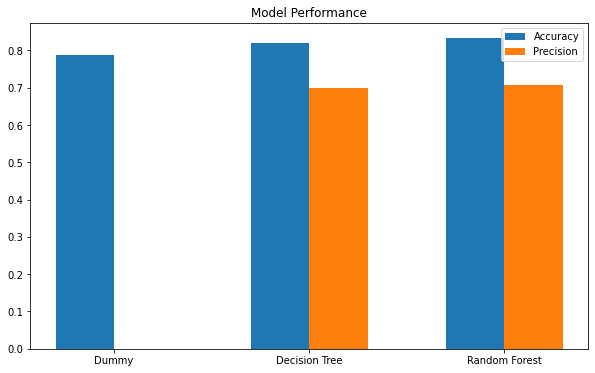

In [43]:
models = ['Dummy', 'Decision Tree', 'Random Forest']
accuracy_scores = [dummy_a, dt2_a, rf2_a]
precision_scores = [0, dt2_p, rf2_p]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3

bar_positions1 = np.arange(len(models))
bar_positions2 = bar_positions1 + bar_width

ax.bar(bar_positions1, accuracy_scores, bar_width, label='Accuracy')
ax.bar(bar_positions2, precision_scores, bar_width, label='Precision')

ax.set_title('Model Performance')
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels(models)
ax.legend();


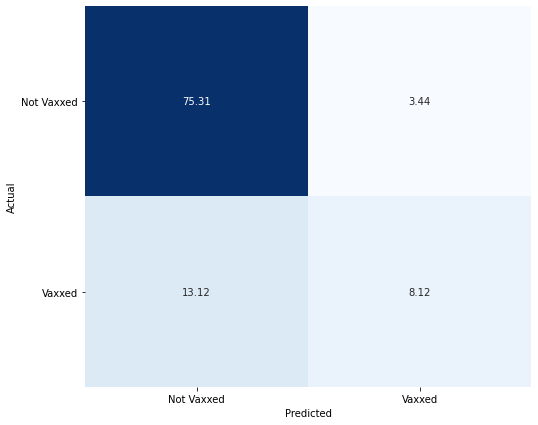

In [44]:
cm = confusion_matrix(y_test, y_pred_final)
cm_percent = cm / np.sum(cm) * 100

# Plot heatmap for final model's confusion matrix for better visualization 
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cbar=False, cmap="Blues");  

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['Not Vaxxed', 'Vaxxed'])
ax.yaxis.set_ticklabels(['Not Vaxxed', 'Vaxxed'], rotation = 0);

## Conclusion

Using this information, we can focus in on the most significant features, respondent's opinion of the vaccine and illness risk as well as medical concern levels. These features can help guide formaton of surveys for private ventures that may not be able to gather personal demographic information as government agencies are able to. This can also guide media advertising to target populations that may be disinclined to get vaccinated. It would also be beneficial to do more research on which combination of features most minimizes the false positives and finds the most vulnerable populations.